In [3]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

In [4]:
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    """
    S: Initial stock price
    K: Option strike price
    T: Time to maturity
    r: Risk-free rate
    sigma: Volatility
    option_type: Type of option ('call' or 'put')
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'")
    
    return option_price

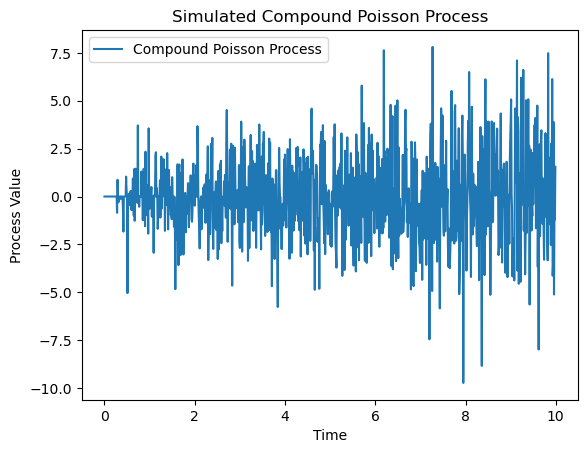

In [5]:
# Parameters
lambda_val = 1.0  # Poisson arrival rate of jumps
jump_mean = 0.0  # Mean of jump sizes
jump_std = 1.0  # Standard deviation of jump sizes
T = 10  # Total time
dt = 0.01  # Time increment

# Simulate Compound Poisson Process
times = np.arange(0, T, dt)
X_t = np.zeros_like(times)
for i, t in enumerate(times[1:], start=1):
    # Number of jumps in [0, t], Poisson distributed
    num_jumps = np.random.poisson(lambda_val * t)
    
    # Generate jump sizes, normally distributed for this example
    jumps = np.random.normal(jump_mean, jump_std, num_jumps)
    
    X_t[i] = np.sum(jumps)

# Plot the simulated process
plt.plot(times, X_t, label='Compound Poisson Process')
plt.xlabel('Time')
plt.ylabel('Process Value')
plt.title('Simulated Compound Poisson Process')
plt.legend()
plt.show()


In [6]:
def monte_carlo_levy_control_variate(S, K, T, r, lambda_val, jump_mean, jump_std, sigma, num_paths):
    dt = 0.01  # Time increment
    times = np.arange(0, T, dt)
    option_payoffs = np.zeros(num_paths)
    bs_prices = np.zeros(num_paths)
    
    for i in range(num_paths):
        X_t = 0  # Initialize the Lévy process value
        for t in times[1:]:
            # Simulate the Lévy process (e.g., compound Poisson process)
            num_jumps = np.random.poisson(lambda_val * dt)
            jumps = np.random.normal(jump_mean, jump_std, num_jumps)
            X_t += np.sum(jumps)
            
            # Simulate the stock price under the Lévy model
            S_t = S * np.exp(r * t + X_t)
        
        # Calculate option payoff at maturity
        option_payoffs[i] = np.maximum(S_t - K, 0)
        
        # Calculate Black-Scholes price as a control variate
        bs_prices[i] = black_scholes_price(S, K, T, r, sigma, option_type='call')
        
    # Compute optimal alpha for control variate adjustment
    cov_matrix = np.cov(option_payoffs, bs_prices)
    alpha_opt = -cov_matrix[0, 1] / cov_matrix[1, 1]
    
    # Adjust option payoffs using Black-Scholes control variate
    adjusted_payoffs = option_payoffs + alpha_opt * (bs_prices - np.mean(bs_prices))
    
    # Estimate option price
    option_price_estimate = np.exp(-r * T) * np.mean(adjusted_payoffs)
    
    return option_price_estimate


In [7]:
monte_carlo_levy_control_variate(S=100, K=100, T=10, r=0.05, lambda_val=1.0, jump_mean=0.0, jump_std=1.0, sigma=0.2, num_paths=10000)

34882.84825076582